# Préparation et Nettoyage des Données
## Projet : Prévision et monitoring des comportements clients


Étape 1 — Imports et chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_excel("../data/online_retail_II.xlsx")


In [2]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Étape 2 — Nettoyage de base

2.1 — Supprimer doublons

In [3]:
df=df.drop_duplicates()

2.2 — Filtrer sur les transactions valides

Quantité > 0

Prix > 0

In [4]:
df=df[(df['Quantity']>0)&(df['Price']>0)]

2.3 — Supprimer les lignes sans Customer ID

In [5]:
df=df.dropna(subset=['Customer ID'])

Étape 3 — Correction des types et colonnes

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Customer ID'] = df['Customer ID'].astype(int)
df['Revenue'] = df['Quantity'] * df['Price']



Étape 4 — Feature Engineering temporel

4.1 — Features calendaires

In [20]:

daily_data['day_of_week'] = daily_data.index.day_name()
daily_data['month'] = daily_data.index.month
daily_data['week_of_year'] = daily_data.index.isocalendar().week
daily_data['day'] = daily_data.index.day


print(daily_data[['day_of_week','month','week_of_year','day']].head(10))


            day_of_week  month  week_of_year  day
InvoiceDate                                      
2009-12-01      Tuesday     12            49    1
2009-12-02    Wednesday     12            49    2
2009-12-03     Thursday     12            49    3
2009-12-04       Friday     12            49    4
2009-12-05     Saturday     12            49    5
2009-12-06       Sunday     12            49    6
2009-12-07       Monday     12            50    7
2009-12-08      Tuesday     12            50    8
2009-12-09    Wednesday     12            50    9
2009-12-10     Thursday     12            50   10


4.2 — Agrégation journalière pour séries temporelles

| Colonne      | Action                                            |
| ------------ | ------------------------------------------------- |
| `'Revenue'`  | `sum` → total des revenus pour ce jour            |
| `'Quantity'` | `sum` → total des quantités vendues ce jour       |
| `'Invoice'`  | `count` → nombre de transactions (lignes) ce jour |


In [8]:
daily_data = df.set_index('InvoiceDate').resample('D').agg({
    'Revenue': 'sum',
    'Quantity': 'sum',
    'Invoice': 'count'  
}).rename(columns={'Invoice': 'Num_Transactions'})


4.3 — Lags et rolling features (pour modèles ML)

On crée  des colonnes pour chaque décalage (1, 7, 14 jours) pour capturer l’effet du passé sur le présent.

.rolling(7).mean() calcule la moyenne sur les 7 derniers jours.

Exemple : Revenue_rolling_7 pour le 8 janvier = moyenne des revenus du 1er au 7 janvier.

Cela lisse les variations quotidiennes et met en évidence les tendances à court terme.

In [9]:
for lag in [1, 7, 14]:
    daily_data[f'Revenue_lag_{lag}'] = daily_data['Revenue'].shift(lag)
    daily_data[f'Quantity_lag_{lag}'] = daily_data['Quantity'].shift(lag)

daily_data['Revenue_rolling_7'] = daily_data['Revenue'].rolling(7).mean()
daily_data['Quantity_rolling_7'] = daily_data['Quantity'].rolling(7).mean()


Étape 5 — Split train/test

In [10]:
split_date = '2010-10-01'
train = daily_data[daily_data.index < split_date]
test = daily_data[daily_data.index >= split_date]


In [11]:
print("Train:", train.shape, "Test:", test.shape)


Train: (304, 11) Test: (70, 11)


Étape 6 — Pipeline

In [12]:
def preprocess(df):
    df = df.drop_duplicates()
    df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]
    df = df.dropna(subset=['Customer ID'])
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['Revenue'] = df['Quantity'] * df['Price']
    df_daily = df.set_index('InvoiceDate').resample('D').agg({
        'Revenue': 'sum', 'Quantity': 'sum', 'Invoice': 'count'
    }).rename(columns={'Invoice':'Num_Transactions'})
    
    # lags
    for lag in [1,7,14]:
        df_daily[f'Revenue_lag_{lag}'] = df_daily['Revenue'].shift(lag)
        df_daily[f'Quantity_lag_{lag}'] = df_daily['Quantity'].shift(lag)
    
    # rolling
    df_daily['Revenue_rolling_7'] = df_daily['Revenue'].rolling(7).mean()
    df_daily['Quantity_rolling_7'] = df_daily['Quantity'].rolling(7).mean()
    
    return df_daily


Étape 7 — Vérification des données

Vérifier valeurs nulles après lags/rolling

In [13]:
daily_data.isna().sum()


Revenue                0
Quantity               0
Num_Transactions       0
Revenue_lag_1          1
Quantity_lag_1         1
Revenue_lag_7          7
Quantity_lag_7         7
Revenue_lag_14        14
Quantity_lag_14       14
Revenue_rolling_7      6
Quantity_rolling_7     6
dtype: int64

In [14]:
daily_data.fillna(0, inplace=True)


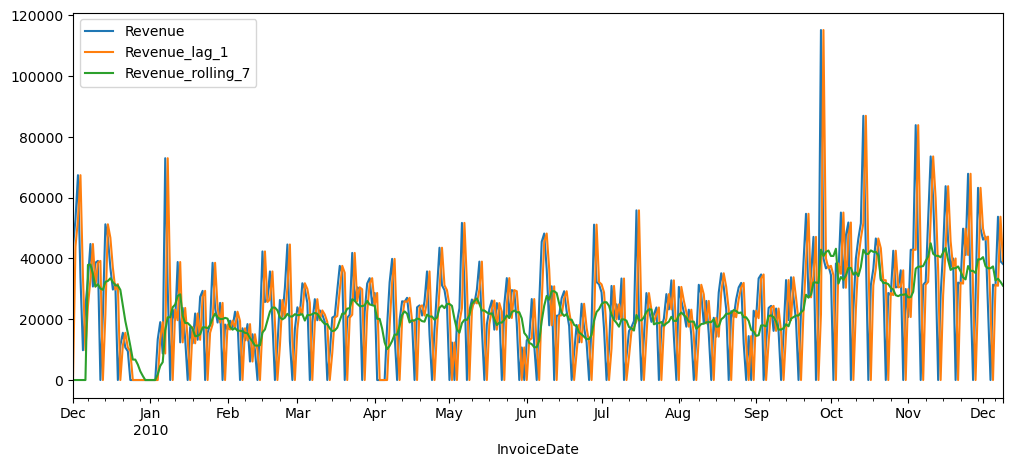

In [15]:
daily_data[['Revenue','Revenue_lag_1','Revenue_rolling_7']].plot(figsize=(12,5))
plt.show()


In [16]:
daily_data.isna().sum()


Revenue               0
Quantity              0
Num_Transactions      0
Revenue_lag_1         0
Quantity_lag_1        0
Revenue_lag_7         0
Quantity_lag_7        0
Revenue_lag_14        0
Quantity_lag_14       0
Revenue_rolling_7     0
Quantity_rolling_7    0
dtype: int64

In [21]:
print(daily_data.columns)


Index(['Revenue', 'Quantity', 'Num_Transactions', 'Revenue_lag_1',
       'Quantity_lag_1', 'Revenue_lag_7', 'Quantity_lag_7', 'Revenue_lag_14',
       'Quantity_lag_14', 'Revenue_rolling_7', 'Quantity_rolling_7',
       'day_of_week', 'month', 'week_of_year', 'day'],
      dtype='object')


In [22]:
daily_data.to_csv('../data/daily_data_preprocessed.csv')
